# ML models for forecasting and other question-answering

## Data Retrieving

In [46]:
"""--Run and CSV-export the following query
SELECT
  AutoWorldProducts.MONTH AS MONTH,
  SUM(AutoWorldOrders.SALES) AS SALES,
  SUM(AutoWorldProducts.UNIT_COSTS * AutoWorldOrders.QUANTITYORDERED) AS COSTS,
  SUM(AutoWorldProducts.UNIT_EXPENSES * AutoWorldOrders.QUANTITYORDERED) AS EXPENSES,
  SUM(AutoWorldOrders.SALES - AutoWorldProducts.UNIT_COSTS * AutoWorldOrders.QUANTITYORDERED) AS UTILITY,
  SUM(AutoWorldOrders.SALES - AutoWorldProducts.UNIT_COSTS * AutoWorldOrders.QUANTITYORDERED)/SUM(AutoWorldOrders.SALES) AS MARGIN
FROM
  `analitica-demos.ChatbotFinanciero_GenAI.AutoWorldOrders` AS AutoWorldOrders
  INNER JOIN `analitica-demos.ChatbotFinanciero_GenAI.AutoWorldProducts` AS AutoWorldProducts 
  ON AutoWorldOrders.PRODUCTLINE = AutoWorldProducts.PRODUCTLINE
  AND DATE_TRUNC(AutoWorldOrders.ORDER_DATE, MONTH) = AutoWorldProducts.MONTH
WHERE
  AutoWorldOrders.ORDER_DATE <= CURRENT_DATE()
GROUP BY
  AutoWorldProducts.MONTH
ORDER BY
  AutoWorldProducts.MONTH;
"""

'--Run and CSV-export the following query\nSELECT\n  AutoWorldProducts.MONTH AS MONTH,\n  SUM(AutoWorldOrders.SALES) AS SALES,\n  SUM(AutoWorldProducts.UNIT_COSTS * AutoWorldOrders.QUANTITYORDERED) AS COSTS,\n  SUM(AutoWorldProducts.UNIT_EXPENSES * AutoWorldOrders.QUANTITYORDERED) AS EXPENSES,\n  SUM(AutoWorldOrders.SALES - AutoWorldProducts.UNIT_COSTS * AutoWorldOrders.QUANTITYORDERED) AS UTILITY,\n  SUM(AutoWorldOrders.SALES - AutoWorldProducts.UNIT_COSTS * AutoWorldOrders.QUANTITYORDERED)/SUM(AutoWorldOrders.SALES) AS MARGIN\nFROM\n  `analitica-demos.ChatbotFinanciero_GenAI.AutoWorldOrders` AS AutoWorldOrders\n  INNER JOIN `analitica-demos.ChatbotFinanciero_GenAI.AutoWorldProducts` AS AutoWorldProducts \n  ON AutoWorldOrders.PRODUCTLINE = AutoWorldProducts.PRODUCTLINE\n  AND DATE_TRUNC(AutoWorldOrders.ORDER_DATE, MONTH) = AutoWorldProducts.MONTH\nWHERE\n  AutoWorldOrders.ORDER_DATE <= CURRENT_DATE()\nGROUP BY\n  AutoWorldProducts.MONTH\nORDER BY\n  AutoWorldProducts.MONTH;\n'

## Data Understanding

In [47]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import pickle

In [48]:
df = pd.read_csv('./AutoWorldMonthlyTotals.csv', sep=',')
TARGET_Y = 'COSTS'
DATECOL = 'MONTH'
OUTFILE = f'{TARGET_Y.lower()}_model.pkl'
df

,MONTH,SALES,COSTS,EXPENSES,UTILITY,MARGIN
0,2022-04-01,1.123732e+05,79216.724358,3387.584204,33156.487836,0.295057
1,2022-05-01,1.205346e+05,86186.450699,4765.137331,34348.162246,0.284965
2,2022-06-01,1.545131e+05,106865.378740,5195.815273,47647.715238,0.308373
3,2022-07-01,1.771611e+05,123970.618419,6404.092659,53190.462355,0.300238
4,2022-08-01,1.868814e+05,128682.895046,6160.781374,58198.538976,0.311420
5,2022-09-01,1.513989e+05,105721.324560,5496.657967,45677.581869,0.301704
6,2022-10-01,1.671336e+05,114465.608443,5647.589044,52667.966786,0.315125
7,2022-11-01,1.853897e+05,129060.001625,6868.871190,56329.669034,0.303845
8,2022-12-01,2.612825e+05,176955.471654,8129.643990,84327.051215,0.322743
9,2023-01-01,5.577836e+05,386334.688398,20132.546571,171448.874457,0.307375


## Data Preparation

In [49]:
last_date = df.iloc[-1][DATECOL]
print("Last date:", last_date)

Last date: 2024-08-01


In [50]:
y = df[TARGET_Y]

In [51]:
base_model = ARIMA(y, order=(25, 1, 3)) # (p, d, q)
model = base_model.fit()

with open(OUTFILE, 'wb') as f:
    pickle.dump(model, f)

print(f"Accuracy: {(1 - mean_absolute_error(y, model.fittedvalues) / y.mean()):.2%}")

Accuracy: 69.85%


In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  COSTS   No. Observations:                   29
Model:                ARIMA(25, 1, 3)   Log Likelihood                -375.435
Date:                Wed, 21 Aug 2024   AIC                            808.870
Time:                        12:48:22   BIC                            847.504
Sample:                             0   HQIC                           820.680
                                 - 29                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1437   1.38e+05  -1.04e-06      1.000   -2.71e+05    2.71e+05
ar.L2         -0.0720   1.47e+05  -4.91e-07      1.000   -2.87e+05    2.87e+05
ar.L3          0.0373   9.07e+04   4.11e-07      1.000   -1.78e+05    1.78e+05
ar.L4         -0.0629   7.75e+04  -8.12e-07      1.000   -1.52e+05    1.52e+05
ar.L5         -0.1251      3e+04  -4.17e-06      1.000   -5.88e+04    5.88e+04
ar.L6         -0.0986   1.88e+04  -5.25e-06      1.000   -3.68e+04    3.68e+04
ar.L7         -0.0165   2.83e+04  -5.83e-07      1.000   -5.54e+04    5.54e+04
ar.L8         -0.0717   3.69e+04  -1.94e-06      1.000   -7.23e+04    7.23e+04
ar.L9          0.0508   1.51e+04   3.36e-06      1.000   -2.97e+04    2.97e+04
ar.L10        -0.0622   3.48e+04  -1.79e-06      1.000   -6.81e+04    6.81e+04
ar.L11        -0.1185   1541.949  -7.68e-05      1.000   -3022.283    3022.046
ar.L12         0.5268    211.116      0.002      0.998    -413.253     414.306
ar.L13         0.0886   1.01e+05   8.79e-07      1.000   -1.97e+05    1.97e+05
ar.L14         0.0292   6.07e+04    4.8e-07      1.000   -1.19e+05    1.19e+05
ar.L15        -0.1067    4.1e+04   -2.6e-06      1.000   -8.04e+04    8.04e+04
ar.L16         0.0071    4.6e+04   1.54e-07      1.000   -9.02e+04    9.02e+04
ar.L17         0.0326   1243.940   2.62e-05      1.000   -2438.046    2438.111
ar.L18         0.0351   1158.039   3.03e-05      1.000   -2269.679    2269.749
ar.L19         0.0045   3900.665   1.14e-06      1.000   -7645.159    7645.168
ar.L20         0.0228   9458.258   2.41e-06      1.000   -1.85e+04    1.85e+04
ar.L21        -0.0404   3237.622  -1.25e-05      1.000   -6345.663    6345.582
ar.L22        -0.0056   1.37e+04  -4.12e-07      1.000   -2.68e+04    2.68e+04
ar.L23        -0.0155   1078.261  -1.44e-05      1.000   -2113.368    2113.337
ar.L24         0.0034   1095.475   3.12e-06      1.000   -2147.089    2147.095
ar.L25        -0.0043   4146.407  -1.03e-06      1.000   -8126.812    8126.803
ma.L1         -0.2802   1.38e+05  -2.03e-06      1.000   -2.71e+05    2.71e+05
ma.L2         -0.1879   2.05e+05  -9.16e-07      1.000   -4.02e+05    4.02e+05
ma.L3         -0.0239   5.62e+04  -4.26e-07      1.000    -1.1e+05     1.1e+05
sigma2      4.296e+10      1.902   2.26e+10      0.000     4.3e+10     4.3e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                15.90
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.56   Skew:                             1.25
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.48e+26. Standard errors may be unsta

In [53]:
print(f"Current data number of periods: {y.size}")

Current data number of periods: 29


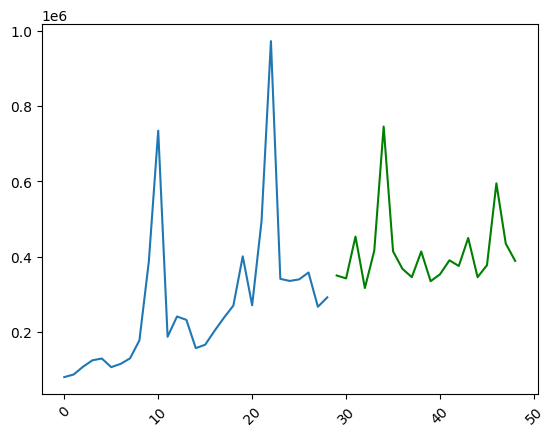

In [54]:
forecast = model.forecast(steps=20)

plt.plot(y)
plt.plot(forecast, color='green')
plt.xticks(rotation=45)
plt.show()

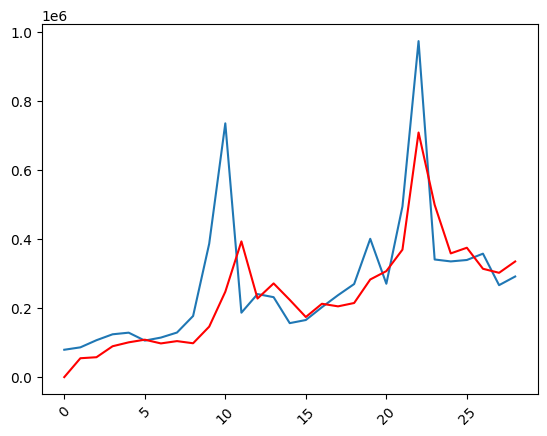

In [55]:
plt.plot(y)
plt.plot(model.fittedvalues, color='red')
plt.xticks(rotation=45)

plt.show()